## Wrangling and Analysis


In this section, we will clean, join perform some basic analysis on the data to answer a few questions.

In [15]:
import re, json
import itertools
from pathlib import Path
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from IPython.display import Image

%matplotlib inline
plt.style.use('ggplot') # setting the style to ggplot

In [ ]:
fname = 'fortune_500_companies.csv' # scrapped data from previous section
path = Path('../data/')             # path to the csv file
df = pd.read_csv(path/fname)        # reading the csv file as a pandas df
df.head()                           # displaying the first 5 rows

 For this excercise, we will primarily focus on :
 - `products` 	
 - `industries` and 	
 - `assets`

In [7]:
with open('../data/infoboxes.json', 'r') as file:
    wiki_data = json.load(file)

In [10]:
wiki_data[0]

{'founder': '[[Sam Walton]]',
 'location_country': 'U.S.',
 'revenue': '{{increase}} {{US$|514.405 billion|link|=|yes}} (2019)',
 'operating_income': '{{increase}} {{US$|21.957 billion}} (2019)',
 'net_income': '{{decrease}} {{US$|6.67 billion}} (2019)',
 'assets': '{{increase}} {{US$|219.295 billion}} (2019)',
 'equity': '{{decrease}} {{US$|79.634 billion}} (2019)',
 'type': '[[Public company|Public]]',
 'industry': '[[Retail]]',
 'products': '{{hlist|Electronics|Movies and music|Home and furniture|Home improvement|Clothing|Footwear|Jewelry|Toys|Health and beauty|Pet supplies|Sporting goods and fitness|Auto|Photo finishing|Craft supplies|Party supplies|Grocery}}',
 'num_employees': '{{plainlist|\n* 2.2|nbsp|million, Worldwide (2018)|ref| name="xbrlus_1" |\n* 1.5|nbsp|million, U.S. (2017)|ref| name="Walmart"|{{cite web |url = http://corporate.walmart.com/our-story/locations/united-states |title = Walmart Locations Around the World – United States |publisher = |url-status=live |archiveu

We can observe that we need to :
- Remove "[[" and "]]" 
- Remove "{{" and "}}"
- Split and seperate by the delimiter "|" in case of `products`
- Only keep alphanumeric and "-" characters

### What type of products are sold by the top 20 companies?

Let's define a few regular expressions to perform the above.

In [12]:
regex1 = re.compile('[\{\[]+(.*?)[\]\}]')

Regex breakdown :

- `[\{\[]+` : match one or more "{" or "]" (\ are used to escape[])
- `(.*?)` : capture anything between the previous pattern and the next
- `[\]\}]` : match ending in either "]" or "}" 


In [13]:
regex2 = re.compile('[^a-zA-Z\- ]') # describe the expr

Similarly : 

- `[^a-zA-Z\- ]` : match anything other than (signified by `^`) `a` to `z` OR `A` to `Z` OR `-` OR empty space. 

Patterns like these are useful for replacing or filtering everything else. Now lets clean and extract the data we need as follows,

In [23]:
products = []
data = []

for x in wiki_data:
    y = x['products'] # get products
    z = regex1.findall(y) # extract all products
    z = [d.lower().split('|') for d in z] # get a list 
    m = list(itertools.chain(*z)) # flatten the list of lists using itertools
    m = [regex2.sub('', t) for t in m  if t != 'hlist'] # remove "hlist" (a rogue token)
    data.append({
                'wiki_title' : x['company_name'], 
                'product' : '|'.join(m)
                })
    products.extend(m)
    
print(products)

['electronics', 'movies and music', 'home and furniture', 'home improvement', 'clothing', 'footwear', 'jewelry', 'toys', 'health and beauty', 'pet supplies', 'sporting goods and fitness', 'auto', 'photo finishing', 'craft supplies', 'party supplies', 'grocery', 'crude oil', 'oil products', 'natural gas', 'petrochemical', 'power generation', 'investment', 'diversified investments', 'insurancetypes', 'property  casualty insurance', 'public utility', 'utilities', 'restaurants', 'food processing', 'aerospace', 'toys', 'mass media', 'media', 'automotive industry', 'automotive', 'sports equipment', 'sporting goods', 'final good', 'consumer products', 'internet', 'real estate', 'macintosh', 'ipod', 'iphone', 'ipad', 'apple watch', 'apple tv', 'homepod', 'macos', 'ios', 'ipados', 'watchos', 'tvos', 'ilife', 'iwork', 'final cut pro', 'logic pro', 'garageband', 'shazam application', 'shazam', 'siri', 'uniprise', 'health care', 'service economics', 'services', 'ingenix', 'pharmaceuticals', 'medic

Now let's create a wordcloud function which will visually inform us about which products are more prominent than the others as follows,

In [38]:
def create_wordcloud(items, stopwords=[]):
    '''create the wordcloud object
    args
    items :     the items we need to display
    stopwords : a list of stopwords to filter out tokens
    ''' 
    
    text = ' '.join(items)
    wordcloud = WordCloud(width=1000, height=800, margin=0, 
                          stopwords=stopwords).generate(text) # max_words=20 

    # display the generated image
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

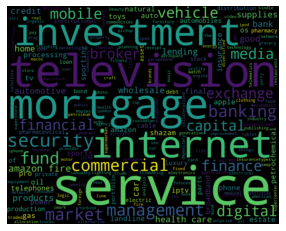

In [39]:
create_wordcloud(products, ['and']) # adding "and" to the stopword list 

### What type of industries do the top 20 company belong from?

In [40]:
regex = re.compile('[\[]+(.*?)[\]]')
industries = []
for i, x in enumerate(wiki_data):
    y = x['industry'] # get industries
    z = regex.findall(y) # extract industries
    z = [d.lower().split('|') for d in z] # get a list
    m = list(itertools.chain(*z)) # flatten
    data[i]['industry'] = '|'.join(m)
    industries.extend(m)

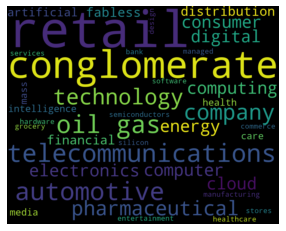

In [41]:
create_wordcloud(industries, ['industry', 'and'])

### What the assets of the top 20 companies look like?

In [596]:
regex = re.compile('([\d\.]+)(?!billion|million|trillion)')
assets = []
for i, x in enumerate(wiki_data):
    y = x['assets'] # get assets
    z = regex.findall(y) # extract assets
    u = re.findall('(billion|million|trillion)', y) # extract the unit
    asset = float(z[0]) # get the numeric value
    unit = u[0]
    data[i]['assets'] = str(asset) + ' ' + unit
    assets.append({x['company_name'] : (asset, unit)})

In [597]:
assets

[{'Walmart': (219.295, 'billion')},
 {'ExxonMobil': (346.2, 'billion')},
 {'Berkshire Hathaway': (707.8, 'billion')},
 {'Apple Inc.': (338.516, 'billion')},
 {'UnitedHealth Group': (173.889, 'billion')},
 {'McKesson Corporation': (60.381, 'billion')},
 {'CVS Health': (196.456, 'billion')},
 {'Amazon (company)': (162.648, 'billion')},
 {'AT&T': (531.0, 'billion')},
 {'General Motors': (227.339, 'billion')},
 {'Ford Motor Company': (256.54, 'billion')},
 {'AmerisourceBergen': (37.66, 'billion')},
 {'Chevron Corporation': (253.9, 'billion')},
 {'Cardinal Health': (39.95, 'billion')},
 {'Costco': (45.4, 'billion')},
 {'Verizon Communications': (264.82, 'billion')},
 {'Kroger': (38.11, 'billion')},
 {'General Electric': (309.129, 'billion')},
 {'Walgreens Boots Alliance': (67.59, 'billion')},
 {'JPMorgan Chase': (2.687, 'trillion')}]

Normalize all the values/units,

In [598]:
for i, asset in enumerate(assets):
    for k, v in asset.items():
        if v[1] == 'trillion':
            assets[i][k] = (v[0]*1000, 'billion')

In [599]:
assets

[{'Walmart': (219.295, 'billion')},
 {'ExxonMobil': (346.2, 'billion')},
 {'Berkshire Hathaway': (707.8, 'billion')},
 {'Apple Inc.': (338.516, 'billion')},
 {'UnitedHealth Group': (173.889, 'billion')},
 {'McKesson Corporation': (60.381, 'billion')},
 {'CVS Health': (196.456, 'billion')},
 {'Amazon (company)': (162.648, 'billion')},
 {'AT&T': (531.0, 'billion')},
 {'General Motors': (227.339, 'billion')},
 {'Ford Motor Company': (256.54, 'billion')},
 {'AmerisourceBergen': (37.66, 'billion')},
 {'Chevron Corporation': (253.9, 'billion')},
 {'Cardinal Health': (39.95, 'billion')},
 {'Costco': (45.4, 'billion')},
 {'Verizon Communications': (264.82, 'billion')},
 {'Kroger': (38.11, 'billion')},
 {'General Electric': (309.129, 'billion')},
 {'Walgreens Boots Alliance': (67.59, 'billion')},
 {'JPMorgan Chase': (2687.0, 'billion')}]

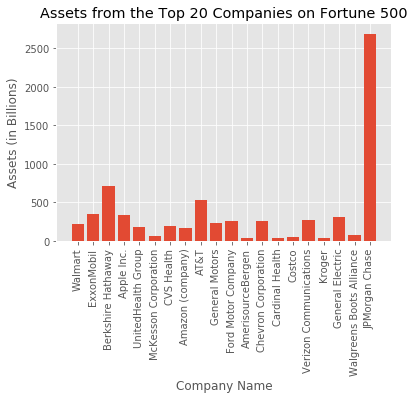

In [602]:
x = [list(a.keys())[0] for a in assets]
energy = [list(a.values())[0][0] for a in assets]
x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, energy)
plt.ylabel("Assets (in Billions)")
plt.xlabel("Company Name")
plt.title("Assets from the Top 20 Companies on Fortune 500")
plt.xticks(x_pos, x, rotation=90)
plt.show()

In [603]:
data

[{'wiki_title': 'Walmart',
  'product': 'electronics|movies and music|home and furniture|home improvement|clothing|footwear|jewelry|toys|health and beauty|pet supplies|sporting goods and fitness|auto|photo finishing|craft supplies|party supplies|grocery',
  'industry': 'retail',
  'assets': '219.295 billion'},
 {'wiki_title': 'ExxonMobil',
  'product': 'crude oil|oil products|natural gas|petrochemical|power generation',
  'industry': 'energy industry|energy|oil and gas industry|oil and gas',
  'assets': '346.2 billion'},
 {'wiki_title': 'Berkshire Hathaway',
  'product': 'investment|diversified investments|insurancetypes|property  casualty insurance|public utility|utilities|restaurants|food processing|aerospace|toys|mass media|media|automotive industry|automotive|sports equipment|sporting goods|final good|consumer products|internet|real estate',
  'industry': 'conglomerate (company)|conglomerate',
  'assets': '707.8 billion'},
 {'wiki_title': 'Apple Inc.',
  'product': 'macintosh|ipod|

In [604]:
df_new = pd.DataFrame(data)
df_new.head()

,wiki_title,product,industry,assets
0,Walmart,electronics|movies and music|home and furnitur...,retail,219.295 billion
1,ExxonMobil,crude oil|oil products|natural gas|petrochemic...,energy industry|energy|oil and gas industry|oi...,346.2 billion
2,Berkshire Hathaway,investment|diversified investments|insurancety...,conglomerate (company)|conglomerate,707.8 billion
3,Apple Inc.,macintosh|ipod|iphone|ipad|apple watch|apple t...,computer hardware|computer software|consumer e...,338.516 billion
4,UnitedHealth Group,uniprise|health care|service economics|service...,managed health care,173.889 billion


In [605]:
df = pd.concat([df_sub, df_new], axis=1)

In [606]:
df.to_csv('./data/top_20_companies.csv', index=False)